In [2]:
import pandas as pd
from PyEMD import EMD, Visualisation
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import pywt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import metrics

from pathlib import Path
import statistics

In [3]:
# 6 iterations
MicSigV1=pd.read_json ('./MicSigV1.json') #(1187,11)
MicSigV1['Data_CIIT_6'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Data_CIIT_6'] = MicSigV1['Data_CIIT_6'].astype('object')
emd = EMD()
#vis = Visualisation()
#plt.plot(t,MicSigV1['Data'][1])
#vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
for ind in range(MicSigV1.shape[0]): 
    
    #1.Decompose noisy input signal into its N subsequent IMFs using EMD.
    data_i=MicSigV1['Data'][ind] 
    emd.emd(np.array(data_i))
    imfs, res = emd.get_imfs_and_residue()
    t = np.arange(0,len(data_i), 1)    
    #2.Denoise, the first IMF, using any thresholding technique.
    N_1=imfs[0].shape[0]
    cov_1=(statistics.median(abs(imfs[0])))/0.675
    T_1 = cov_1*((2*np.log(N_1))**0.5)
    signs_1 = [np.sign(imfs[0][j]) for j in range(imfs[0].shape[0])]
    sign_change_1 = [0]
    imfs_1 = np.zeros(imfs[0].shape[0])
    for sign_1 in range(len(signs_1)-1):
        if signs_1[sign_1] != signs_1[sign_1+1]:
            sign_change_1.append(sign_1+1)  
    for j in range(len(sign_change_1)-1):
        start_point_1=sign_change_1[j]
        end_point_1=sign_change_1[j+1]
        imf_range_1=imfs[0][start_point_1:end_point_1]
        extrema_1 = max(abs(imf_range_1))
        if extrema_1 > T_1:
            pos_range_1= np.arange(start_point_1,end_point_1)
            for k in range(len(pos_range_1)):
                pos = pos_range_1[k]
                val = imf_range_1[k]*((extrema_1-T_1)/extrema_1)
                imfs_1[pos] = val
    #3.Compute the actual noise signal that existed
    noise_signal = imfs[0]- imfs_1
    #4.Perform a partial reconstruction using the last L − 1 IMFs plus the information signal contained in 1st IMF
    imfs[0] = imfs_1
    MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
    for col_i in range(MicSigV1_CIIT.shape[0]):
        for row_i in range(imfs.shape[0]):
            MicSigV1_CIIT[col_i] += imfs[row_i][col_i]
    seed=0
    #5.Randomly alter the sample positions of the noise - only part of the first IMF
    noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
    MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
    #6.Repeat
    M_CIIT_max = 5
    M_CIIT = 1
    M_CIIT_obs =np.zeros((M_CIIT_max+1,imfs.shape[1]))
    M_CIIT_obs[0] = MicSigV1_CIIT
    
    while M_CIIT <= M_CIIT_max:
        data_i= MicSigV1_CIIT
        emd.emd(np.array(data_i))
        imfs, res = emd.get_imfs_and_residue()
        row=imfs.shape[0]
        col=imfs.shape[1]
        imfs_filter = np.zeros((row,col))
        for i in range(imfs.shape[0]):
            N_i=imfs[i].shape[0]
            cov_i=(statistics.median(abs(imfs[i])))/0.675
            T_i = cov_i*((2*np.log(N_i))**0.5)
            signs = [np.sign(imfs[i][j]) for j in range(imfs[i].shape[0])]
            sign_change = [0]   
            for sign in range(len(signs)-1):
                if signs[sign] != signs[sign+1]:
                    sign_change.append(sign+1)
            for j in range(len(sign_change)-1):
                start_point=sign_change[j]
                end_point=sign_change[j+1]
                imf_range=imfs[i][start_point:end_point]
                extrema = max(abs(imf_range))
                if extrema > T_i:
                    pos_range= np.arange(start_point,end_point)
                    for k in range(len(pos_range)):
                        pos = pos_range[k]
                        val=imf_range[k]*((extrema-T_i)/extrema)
                        imfs_filter[i][pos] = val
        
        noise_signal = imfs[0]- imfs_filter[0]
        MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
        for col_i in range(MicSigV1_CIIT.shape[0]):
            for row_i in range(imfs_filter.shape[0]):
                MicSigV1_CIIT[col_i] += imfs_filter[row_i][col_i]   
        seed=0
        noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
        MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
        M_CIIT_obs[M_CIIT] = MicSigV1_CIIT
        M_CIIT =M_CIIT+1
        
    MicSigV1_CIIT_avg=np.average(M_CIIT_obs,axis=0)
    MicSigV1.at[ind, 'Data_CIIT_6'] = list(MicSigV1_CIIT_avg)        

In [4]:
# 4 iterations
MicSigV1['Data_CIIT_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Data_CIIT_4'] = MicSigV1['Data_CIIT_4'].astype('object')

for ind in range(MicSigV1.shape[0]): #
    #1.Decompose noisy input signal into its N subsequent IMFs using EMD.
    data_i=MicSigV1['Data'][ind] 
    emd.emd(np.array(data_i))
    imfs, res = emd.get_imfs_and_residue()
    t = np.arange(0,len(data_i), 1)    
    #2.Denoise, the first IMF, using any thresholding technique.
    N_1=imfs[0].shape[0]
    cov_1=(statistics.median(abs(imfs[0])))/0.675
    T_1 = cov_1*((2*np.log(N_1))**0.5)
    signs_1 = [np.sign(imfs[0][j]) for j in range(imfs[0].shape[0])]
    sign_change_1 = [0]
    imfs_1 = np.zeros(imfs[0].shape[0])
    for sign_1 in range(len(signs_1)-1):
        if signs_1[sign_1] != signs_1[sign_1+1]:
            sign_change_1.append(sign_1+1)  
    for j in range(len(sign_change_1)-1):
        start_point_1=sign_change_1[j]
        end_point_1=sign_change_1[j+1]
        imf_range_1=imfs[0][start_point_1:end_point_1]
        extrema_1 = max(abs(imf_range_1))
        if extrema_1 > T_1:
            pos_range_1= np.arange(start_point_1,end_point_1)
            for k in range(len(pos_range_1)):
                pos = pos_range_1[k]
                val = imf_range_1[k]*((extrema_1-T_1)/extrema_1)
                imfs_1[pos] = val
    #3.Compute the actual noise signal that existed
    noise_signal = imfs[0]- imfs_1
    #4.Perform a partial reconstruction using the last L − 1 IMFs plus the information signal contained in 1st IMF
    imfs[0] = imfs_1
    MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
    for col_i in range(MicSigV1_CIIT.shape[0]):
        for row_i in range(imfs.shape[0]):
            MicSigV1_CIIT[col_i] += imfs[row_i][col_i]
    seed=0
    #5.Randomly alter the sample positions of the noise-only part of the first IMF
    noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
    MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
    #6.Repeat
    M_CIIT_max = 3
    M_CIIT = 1
    M_CIIT_obs =np.zeros((M_CIIT_max+1,imfs.shape[1]))
    M_CIIT_obs[0] = MicSigV1_CIIT
    
    while M_CIIT <= M_CIIT_max:
        data_i= MicSigV1_CIIT
        emd.emd(np.array(data_i))
        imfs, res = emd.get_imfs_and_residue()
        row=imfs.shape[0]
        col=imfs.shape[1]
        imfs_filter = np.zeros((row,col))
        for i in range(imfs.shape[0]):
            N_i=imfs[i].shape[0]
            cov_i=(statistics.median(abs(imfs[i])))/0.675
            T_i = cov_i*((2*np.log(N_i))**0.5)
            signs = [np.sign(imfs[i][j]) for j in range(imfs[i].shape[0])]
            sign_change = [0]   
            for sign in range(len(signs)-1):
                if signs[sign] != signs[sign+1]:
                    sign_change.append(sign+1)
            for j in range(len(sign_change)-1):
                start_point=sign_change[j]
                end_point=sign_change[j+1]
                imf_range=imfs[i][start_point:end_point]
                extrema = max(abs(imf_range))
                if extrema > T_i:
                    pos_range= np.arange(start_point,end_point)
                    for k in range(len(pos_range)):
                        pos = pos_range[k]
                        val=imf_range[k]*((extrema-T_i)/extrema)
                        imfs_filter[i][pos] = val
        
        noise_signal = imfs[0]- imfs_filter[0]
        MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
        for col_i in range(MicSigV1_CIIT.shape[0]):
            for row_i in range(imfs_filter.shape[0]):
                MicSigV1_CIIT[col_i] += imfs_filter[row_i][col_i]   
        seed=0
        noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
        MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
        M_CIIT_obs[M_CIIT] = MicSigV1_CIIT
        M_CIIT =M_CIIT+1
        
    MicSigV1_CIIT_avg=np.average(M_CIIT_obs,axis=0)
    MicSigV1.at[ind, 'Data_CIIT_4'] = list(MicSigV1_CIIT_avg)        

In [5]:
# 2 iterations
MicSigV1['Data_CIIT_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Data_CIIT_2'] = MicSigV1['Data_CIIT_2'].astype('object')

for ind in range(MicSigV1.shape[0]): #
    #1.Decompose noisy input signal into its N subsequent IMFs using EMD.
    data_i=MicSigV1['Data'][ind] 
    emd.emd(np.array(data_i))
    imfs, res = emd.get_imfs_and_residue()
    t = np.arange(0,len(data_i), 1)    
    #2.Denoise, the first IMF, using any thresholding technique.
    N_1=imfs[0].shape[0]
    cov_1=(statistics.median(abs(imfs[0])))/0.675
    T_1 = cov_1*((2*np.log(N_1))**0.5)
    signs_1 = [np.sign(imfs[0][j]) for j in range(imfs[0].shape[0])]
    sign_change_1 = [0]
    imfs_1 = np.zeros(imfs[0].shape[0])
    for sign_1 in range(len(signs_1)-1):
        if signs_1[sign_1] != signs_1[sign_1+1]:
            sign_change_1.append(sign_1+1)  
    for j in range(len(sign_change_1)-1):
        start_point_1=sign_change_1[j]
        end_point_1=sign_change_1[j+1]
        imf_range_1=imfs[0][start_point_1:end_point_1]
        extrema_1 = max(abs(imf_range_1))
        if extrema_1 > T_1:
            pos_range_1= np.arange(start_point_1,end_point_1)
            for k in range(len(pos_range_1)):
                pos = pos_range_1[k]
                val = imf_range_1[k]*((extrema_1-T_1)/extrema_1)
                imfs_1[pos] = val
    #3.Compute the actual noise signal that existed
    noise_signal = imfs[0]- imfs_1
    #4.Perform a partial reconstruction using the last L − 1 IMFs plus the information signal contained in 1st IMF
    imfs[0] = imfs_1
    MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
    for col_i in range(MicSigV1_CIIT.shape[0]):
        for row_i in range(imfs.shape[0]):
            MicSigV1_CIIT[col_i] += imfs[row_i][col_i]
    seed=0
    #5.Randomly alter the sample positions o fthe noise-only part of the first IMF
    noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
    MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
    #6.Repeat
    M_CIIT_max = 1
    M_CIIT = 1
    M_CIIT_obs =np.zeros((M_CIIT_max+1,imfs.shape[1]))
    M_CIIT_obs[0] = MicSigV1_CIIT
    
    while M_CIIT <= M_CIIT_max:
        data_i= MicSigV1_CIIT
        emd.emd(np.array(data_i))
        imfs, res = emd.get_imfs_and_residue()
        row=imfs.shape[0]
        col=imfs.shape[1]
        imfs_filter = np.zeros((row,col))
        for i in range(imfs.shape[0]):
            N_i=imfs[i].shape[0]
            cov_i=(statistics.median(abs(imfs[i])))/0.675
            T_i = cov_i*((2*np.log(N_i))**0.5)
            signs = [np.sign(imfs[i][j]) for j in range(imfs[i].shape[0])]
            sign_change = [0]   
            for sign in range(len(signs)-1):
                if signs[sign] != signs[sign+1]:
                    sign_change.append(sign+1)
            for j in range(len(sign_change)-1):
                start_point=sign_change[j]
                end_point=sign_change[j+1]
                imf_range=imfs[i][start_point:end_point]
                extrema = max(abs(imf_range))
                if extrema > T_i:
                    pos_range= np.arange(start_point,end_point)
                    for k in range(len(pos_range)):
                        pos = pos_range[k]
                        val=imf_range[k]*((extrema-T_i)/extrema)
                        imfs_filter[i][pos] = val
        
        noise_signal = imfs[0]- imfs_filter[0]
        MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
        for col_i in range(MicSigV1_CIIT.shape[0]):
            for row_i in range(imfs_filter.shape[0]):
                MicSigV1_CIIT[col_i] += imfs_filter[row_i][col_i]   
        seed=0
        noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
        MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
        M_CIIT_obs[M_CIIT] = MicSigV1_CIIT
        M_CIIT =M_CIIT+1
        
    MicSigV1_CIIT_avg=np.average(M_CIIT_obs,axis=0)
    MicSigV1.at[ind, 'Data_CIIT_2'] = list(MicSigV1_CIIT_avg)  

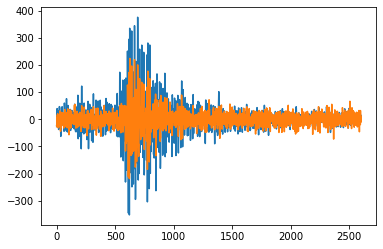

In [6]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data'][1185])
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data_CIIT_2'][1185])

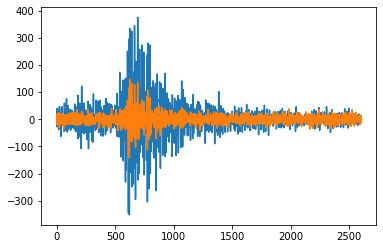

In [7]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data'][1185])
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data_CIIT_4'][1185])

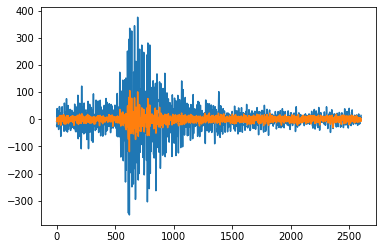

In [8]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data'][1185])
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data_CIIT_6'][1185])

In [9]:
#normalize the data in the range (-1,1)

def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))

scaler = MinMaxScaler(feature_range=(-1, 1))

MicSigV1['NORM_CIIT_6'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT_6'] = MicSigV1['NORM_CIIT_6'].astype('object')
MicSigV1['NORM_CIIT_4'] = MicSigV1['NORM_CIIT_4'].astype('object')
MicSigV1['NORM_CIIT_2'] = MicSigV1['NORM_CIIT_2'].astype('object')
MicSigV1['NORM_CIIT'] = MicSigV1['NORM_CIIT'].astype('object')

stn_array_original = []
for ind in range(MicSigV1['Data'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data'][ind]])
    signal = MicSigV1['Data'][ind]
    MicSigV1.at[ind, 'NORM_CIIT'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))

stn_array_2iter = []
for ind in range(MicSigV1['Data_CIIT_2'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data_CIIT_2'][ind]])
    signal = MicSigV1['Data_CIIT_2'][ind]
    MicSigV1.at[ind, 'NORM_CIIT_2'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))

stn_array_4iter = []
for ind in range(MicSigV1['Data_CIIT_4'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data_CIIT_4'][ind]])
    signal = MicSigV1['Data_CIIT_4'][ind]
    MicSigV1.at[ind, 'NORM_CIIT_4'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))

stn_array_6iter = []
for ind in range(MicSigV1['Data_CIIT_6'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data_CIIT_6'][ind]])
    signal = MicSigV1['Data_CIIT_6'][ind]
    MicSigV1.at[ind, 'NORM_CIIT_6'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))


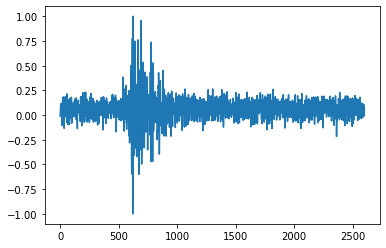

In [10]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['NORM_CIIT_6'][1185])

In [11]:
#First Dimension: the Maximum Threshold Frequency (20-30 Hz) #f26 
#code from https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html

MicSigV1['Freq_Raw'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Freq_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Freq_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Freq_6'] = np.zeros((MicSigV1.shape[0]))

for ind in range((MicSigV1.shape[0])):
    duration = MicSigV1['Duration'][ind]
    f_s=len(MicSigV1['Data'][ind])/duration
    freq=len(MicSigV1['Data'][ind])
    X_raw = fftpack.fft(MicSigV1['NORM_CIIT'][ind])
    X_2 = fftpack.fft(MicSigV1['NORM_CIIT_2'][ind])
    X_4 = fftpack.fft(MicSigV1['NORM_CIIT_4'][ind])
    X_6 = fftpack.fft(MicSigV1['NORM_CIIT_6'][ind])
    freqs = fftpack.fftfreq(freq) * f_s
    index_list =[ind for ind,val in enumerate(freqs) if val <=30 and val >=20 ]
    MicSigV1.loc[ind,"Freq_Raw"]=freqs[np.where(X_raw==max(X_raw[index_list]))[0][0]]
    MicSigV1.loc[ind,'Freq_2']= freqs[np.where(X_2==max(X_2[index_list]))[0][0]]  
    MicSigV1.loc[ind,'Freq_4']= freqs[np.where(X_4==max(X_4[index_list]))[0][0]] 
    MicSigV1.loc[ind,'Freq_6']= freqs[np.where(X_6==max(X_6[index_list]))[0][0]] 

In [12]:
#2nd Dimension: D1 Max. peak in freq.-domain  
waveletname= 'sym6'
MicSigV1['D1_Max_Raw'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['D1_Max_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['D1_Max_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['D1_Max_6'] = np.zeros((MicSigV1.shape[0]))

for ind in range((MicSigV1.shape[0])):
    duration = MicSigV1['Duration'][ind]
    #normalized raw data
    data_raw = MicSigV1['Data'][ind]
    (data_raw, coeff_d) = pywt.dwt(data_raw, waveletname)
    f_s_raw=len(data_raw)/duration
    freq_raw=len(data_raw)
    X_raw = fftpack.fft(data_raw)
    freqs_raw = fftpack.fftfreq(freq_raw) * f_s_raw
    MicSigV1.loc[ind,'D1_Max_Raw']=freqs_raw[np.where(X_raw==np.max(X_raw))[0][0]]
    #normalized data after CIIT 2 iterations
    data2 = MicSigV1['Data_CIIT_2'][ind]
    (data2, coeff_d) = pywt.dwt(data2, waveletname)
    f_s2=len(data2)/duration
    freq2=len(data2)
    X2 = fftpack.fft(data2)
    freqs2 = fftpack.fftfreq(freq2) * f_s2
    MicSigV1.loc[ind,'D1_Max_2']=freqs2[np.where(X2==np.max(X2))[0][0]]
    #normalized data after CIIT 4 iterations
    data4 = MicSigV1['Data_CIIT_4'][ind]
    (data4, coeff_d) = pywt.dwt(data4, waveletname)
    f_s4=len(data4)/duration
    freq4=len(data4)
    X4 = fftpack.fft(data4)
    freqs4 = fftpack.fftfreq(freq4) * f_s4
    MicSigV1.loc[ind,'D1_Max_4']=freqs4[np.where(X4==np.max(X4))[0][0]]
    #normalized data after CIIT 6 iterations
    data6 = MicSigV1['Data_CIIT_6'][ind]
    (data6, coeff_d) = pywt.dwt(data6, waveletname)
    f_s6=len(data6)/duration
    freq6=len(data6)
    X6 = fftpack.fft(data6)
    freqs6 = fftpack.fftfreq(freq6) * f_s6
    MicSigV1.loc[ind,'D1_Max_6']=freqs6[np.where(X6==np.max(X6))[0][0]]


In [13]:
# 3rd Dimension: the entropy in the time domain
MicSigV1['E_Raw'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['E_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['E_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['E_6'] = np.zeros((MicSigV1.shape[0]))
for ind in range((MicSigV1.shape[0])):
    data_raw = MicSigV1['NORM_CIIT'][ind]
    data2 = MicSigV1['NORM_CIIT_2'][ind]
    data4 = MicSigV1['NORM_CIIT_4'][ind]
    data6 = MicSigV1['NORM_CIIT_6'][ind]
    MicSigV1.loc[ind,'E_Raw'] = - np.sum([ (x**2)*np.log(x**2) for x in data_raw ])
    MicSigV1.loc[ind,'E_2'] = - np.sum([ (x**2)*np.log(x**2) for x in data2 ])
    MicSigV1.loc[ind,'E_4'] = - np.sum([ (x**2)*np.log(x**2) for x in data4 ])
    MicSigV1.loc[ind,'E_6'] = - np.sum([ (x**2)*np.log(x**2) for x in data6 ])

In [ ]:
output_file = 'clean_data.parquet'
output_dir = Path()#Path('etl_output/')
full_path = output_dir/output_file

output_dir.mkdir(parents=True, exist_ok=True)
MicSigV1.to_parquet(full_path)
print(f"saved file t: {full_path}")